In [1]:
import numpy as np

In [2]:
%env JAX_ENABLE_X64=True

env: JAX_ENABLE_X64=True


In [3]:
from lenstronomy.LensModel.lens_model import LensModel
import lensinggw.constants.constants as const
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle

In [4]:
from wolensing.plot.plot import plot_contour
import wolensing.amplification_factor.amplification_factor as af

The macroimage where the microlens is placed around.

In [5]:
type2 = False

In [6]:
ym = 0.8
angle = np.radians(float(0))

Importing constants

In [7]:
G = const.G  # gravitational constant [m^3 kg^-1 s^-2]
c = const.c  # speed of light [m/s]
M_sun = const.M_sun  # Solar mass [Kg]

In [8]:
y0, y1 = 0.5, 0 # source position
l0, l1 = 0., 0 # lens position

zS = 1.0 # source redshift
zL = 0.5 # lens redshift

In [9]:
mL1 = 1e10
mL2 = 20
mtot = mL1 + mL2

# convert to radians
from lensinggw.utils.utils import param_processing
thetaE1 = param_processing(zL, zS, mL1)
thetaE2 = param_processing(zL, zS, mL2)
thetaE = param_processing(zL, zS, mtot)

In [10]:
beta0, beta1 = y0 * thetaE, y1 * thetaE
eta10, eta11 = 0 * l0 * thetaE, 0 * l1 * thetaE
lens_model_list = ['SIS']
kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
kwargs_lens_list = [kwargs_sis_1]

kwargs_sis_1_scaled = {'center_x': eta10 / thetaE, 'center_y': eta11 / thetaE, 'theta_E': thetaE1 / thetaE}
kwargs_lens_list_scaled = [kwargs_sis_1_scaled]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 5 * thetaE2,
                 'OverlapDistMacro': 1e-17,
                 'OnlyMacro': True}
MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                     source_pos_y=beta1,
                                                     lens_model_list=lens_model_list,
                                                     kwargs_lens=kwargs_lens_list,
                                                     **solver_kwargs)

Td = TimeDelay(MacroImg_ra, MacroImg_dec,
                beta0, beta1,
                zL, zS,
                lens_model_list, kwargs_lens_list)
Mus = magnifications(MacroImg_ra, MacroImg_dec, lens_model_list, kwargs_lens_list)
if type2:
    microtype = np.nonzero(Td)[0][0]
else:
    microtype = np.where(Td==0)[0][0]

masses = [100]
angle = [0]
ym = [.95]

num_points = len(masses)
for j in range(0,num_points):
    thetaE = param_processing(zL, zS, masses[j])# lens model
    #positioning the microlenses
    eta20 = MacroImg_ra[microtype] + ym[j]*np.cos(np.radians(angle[j])) * thetaE
    eta21 = MacroImg_dec[microtype] + ym[j] * np.sin(np.radians(angle[j])) * thetaE
    lens_model_list.append('POINT_MASS')
    kwargs_lens_list.append({'center_x': eta20, 'center_y': eta21, 'theta_E': thetaE})
    
# Injecting microlens around desired macroimage
# eta20, eta21 = MacroImg_ra[microtype] + np.cos(angle)*ym*thetaE2, MacroImg_dec[microtype] + np.sin(angle)*ym*thetaE2
# lens_model_list = ['SIS', 'POINT_MASS']
# kwargs_sis_1 = {'center_x': eta10, 'center_y': eta11, 'theta_E': thetaE1}
# kwargs_point_mass_2 = {'center_x': eta20, 'center_y': eta21, 'theta_E': thetaE2}
# kwargs_lens_list = [kwargs_sis_1, kwargs_point_mass_2]

from lensinggw.solver.images import microimages
solver_kwargs = {'SearchWindowMacro': 10 * thetaE1,
                 'SearchWindow': 10 * thetaE2,
                 'Pixels': 2*1e3,
                 'Optimization': True,
                 'OverlapDist': 1e-18,
                 'OverlapDistMacro': 1e-17}
solver_kwargs.update({'Improvement' : 0.1})
solver_kwargs.update({'MinDist' : 10**(-7)})

Img_ra, Img_dec, MacroImg_ra, MacroImg_dec, pixel_width = microimages(source_pos_x=beta0,
                                                                      source_pos_y=beta1,
                                                                      lens_model_list=lens_model_list,
                                                                      kwargs_lens=kwargs_lens_list,
                                                                      **solver_kwargs)
Images_dict = {'Source_ra': beta0,
               'Source_dec': beta1,
               'Img_ra': Img_ra,
               'Img_dec': Img_dec,
               'MacroImg_ra': MacroImg_ra,
               'MacroImg_dec': MacroImg_dec,
               'Microlens_ra': [eta20],
               'Microlens_dec': [eta21],
               'thetaE': thetaE}

# time delays, magnifications, Morse indices 
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
from lensinggw.amplification_factor.amplification_factor import geometricalOpticsMagnification
tds = TimeDelay(Img_ra, Img_dec,
               beta0, beta1,
               zL, zS,
               lens_model_list, kwargs_lens_list)
mus = magnifications(Img_ra, Img_dec, lens_model_list, kwargs_lens_list)
ns = getMinMaxSaddle(Img_ra, Img_dec, lens_model_list, kwargs_lens_list, diff = None)
print('Time delays (seconds): ', tds)
print('magnifications: ', mus)
print('Morse indices: ', ns)
    
lens_model_complete = LensModel(lens_model_list=lens_model_list)
T = lens_model_complete.fermat_potential
T0 = thetaE ** (-2) * T(Img_ra[microtype], Img_dec[microtype], kwargs_lens_list, beta0, beta1)#[0]
if not isinstance(T0, float):
    T0 = T0[0]
Tscale = 4 * (1 + zL) * mtot * M_sun * G / c ** 3
print('T0 = {}'.format(T0))
print('Tscale = {}'.format(Tscale))

/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:107: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:107: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:108: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:117: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packages/lensinggw-1.0.0-py3.10.egg/lensinggw/solver/images.py:117: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/manchun.yeung/.conda/envs/wolensing/lib/python3.10/site-packa


---- Will perform only the macromodel analysis ----

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro         --> True
Scaled            --> False
SearchWindowMacro --> 8.052888061582412e-06
PixelsMacro       --> 1000
PrecisionLimit    --> 1e-20
OverlapDistMacro  --> 1e-17
NearSource        --> False
Optimization      --> False
Verbose           --> False




MACROIMAGES

ra: [-4.02644403e-07  1.20793321e-06]
dec: [-4.23516474e-22 -4.23516474e-22]


---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro                       --> False
Scaled                          --> False
SearchWindowMacro               --> 8.052888061582412e-06
PixelsMacro                     --> 1000
OverlapDistMacro                --> 1e-17
NearSource                      --> False
Optimization                    --> True
Verbose                         --> False
OptimizationWindowMacro         --> 

In [11]:
from wolensing.lensmodels.potential import potential
potential(lens_model_list, Img_ra[1], 0, np.array([beta0, beta1]), kwargs_lens_list)

Array([[ 8.10152040e-14, -8.91642884e-13]], dtype=float64)

In [12]:
Img_ra[1], Img_dec[1]

(1.2078949594524248e-06, -7.929545514873374e-11)

In [13]:
beta0

4.0264440348176497e-07

In [14]:
# plot only the microimages around the desired macroimage
Img_ra = np.delete(Img_ra, [0])
Img_dec = np.delete(Img_dec, [0])

[-4.02644403e-07  1.20793321e-06] [-4.23516474e-22 -4.23516474e-22] Img_pos


<Axes: >

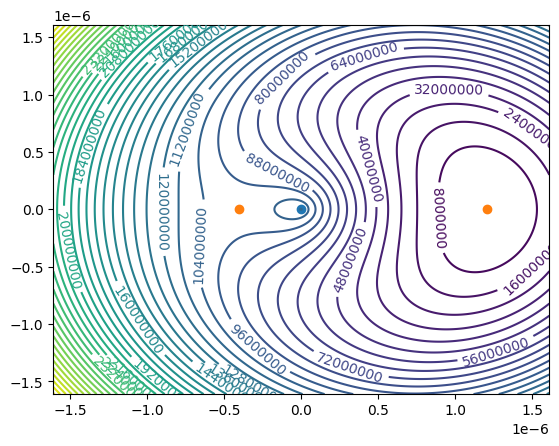

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plot_contour(ax, lens_model_list, eta10, eta11, 4*thetaE1, kwargs_lens_list, beta0, beta1, MacroImg_ra, MacroImg_dec,
                    T0 = T0, Tfac = (thetaE)**(-2), micro=False)


In [16]:
T0 = thetaE ** (-2) * T(MacroImg_ra[1], MacroImg_dec[1], kwargs_lens_list, beta0, beta1)#[0]
T0

-99999976.75630146

[1.20789496e-06 1.20788231e-06 1.20789496e-06 1.20806061e-06] [-7.92954551e-11 -8.44895547e-21  7.92954551e-11 -5.78607669e-22] Img_pos


<Axes: >

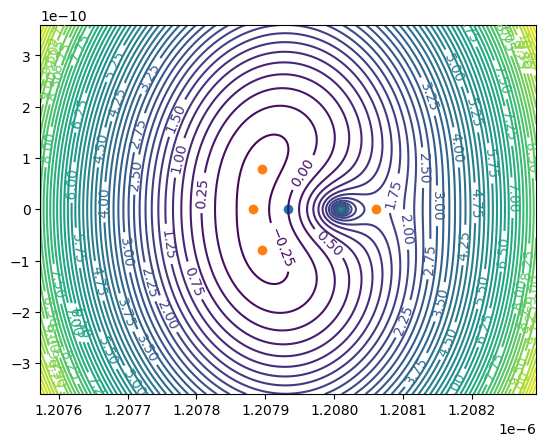

In [17]:
fig1, ax1 = plt.subplots()
plot_contour(ax1, lens_model_list, MacroImg_ra[microtype], MacroImg_dec[microtype], 20*thetaE2, kwargs_lens_list, beta0, beta1, Img_ra, Img_dec,
                    T0 = T0, Tfac = (thetaE)**(-2), micro=True)

In [18]:
T0

-99999976.75630146

In [19]:
# Define the characteristic WindowSize
mL3 = 10
thetaE3 = param_processing(zL, zS, mL3)

In [20]:
import time

start


Integrating...: 100%|██████████| 441/441 [03:30<00:00,  2.09it/s]


total time 24.99999


<Figure size 640x480 with 0 Axes>

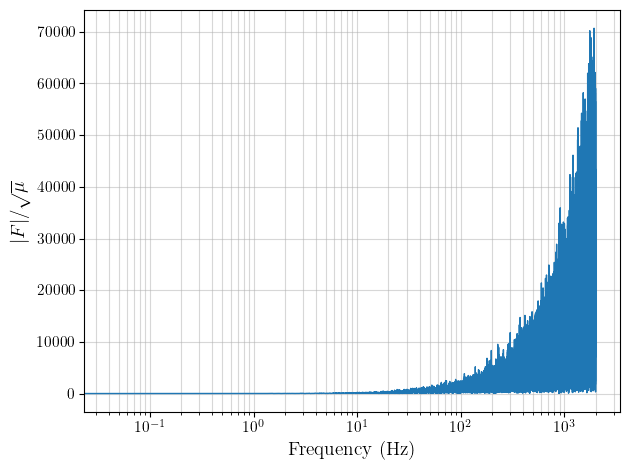

<Axes: xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [21]:
kwargs_macro = {'source_pos_x': beta0,
                'source_pos_y': beta1,
                'theta_E': thetaE,
                'mu': np.abs(Mus[microtype]),
               }

kwargs_integrator = {'PixelNum': int(40000),
                     'PixelBlockMax': 2000,
                     'WindowSize': 2.*210*thetaE3,
                     'WindowCenterX': MacroImg_ra[microtype],
                     'WindowCenterY': MacroImg_dec[microtype],
                     'T0': T0,
                     'TimeStep': 1e-5/Tscale, 
                     'TimeMax': T0 + 10/Tscale,
                     'TimeMin': T0 - 5/Tscale,
                     'TimeLength': 15/Tscale,
                     'TExtend': 10/Tscale,
                     'LastImageT': .02/Tscale,
                     'Tbuffer': .1/Tscale,
                     'Tscale': Tscale}


amplification = af.amplification_factor(lens_model_list=lens_model_list, kwargs_lens=kwargs_lens_list, kwargs_macro=kwargs_macro, **kwargs_integrator)
ts, Ft = amplification.integrator(gpu=True)
ws, Fws = amplification.fourier()
amplification.plot_freq()

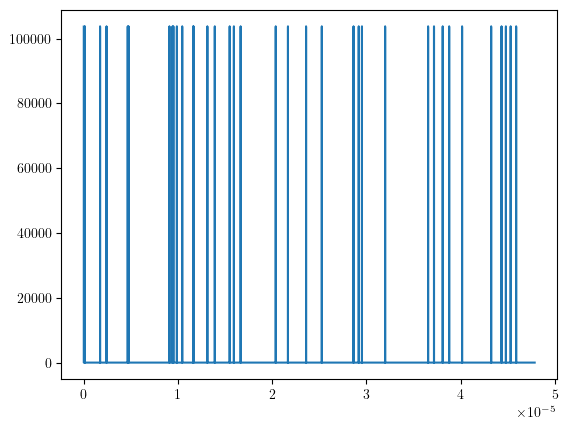

In [22]:
plt.plot(ts, Ft)

<Figure size 640x480 with 0 Axes>

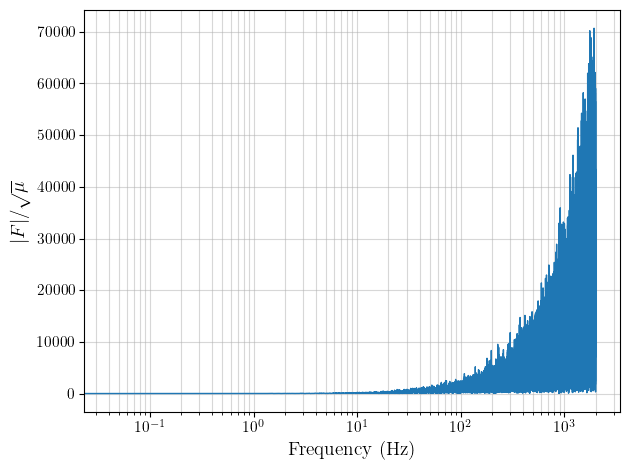

<Axes: xlabel='Frequency (Hz)', ylabel='$|F|/\\sqrt{\\mu}$'>

In [23]:
amplification.plot_freq(smooth=False)

<Figure size 640x480 with 0 Axes>

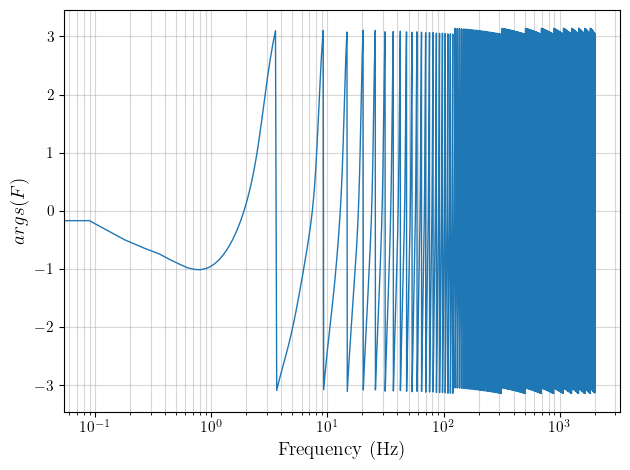

<Axes: xlabel='Frequency (Hz)', ylabel='$args(F)$'>

In [19]:
amplification.plot_freq(pha=True, smooth=False)

# Geometrical optics
To get the geometrical optics around type 1 image, we need the magnifications, time delay and the image positions of the microimages

In [20]:
mus = mus[1:]
tds = tds[1:]

In [21]:
mus

array([-0.2       , -0.19999076, -0.20000924])

In [22]:
geofs, geoFws = amplification.geometrical_optics(mus, tds, Img_ra, Img_dec, upper_lim=2000)

In [23]:
from wolensing.utils.utils import *
ns = Morse_indices(amplification._lens_model_list, Img_ra, Img_dec, amplification._kwargs_lens)

In [24]:
ns

array([0.5, 0.5, 0.5])

In [25]:
Fmag = 0
for i in range(len(mus)):
    Fmag += np.sqrt(np.abs(mus[i]))* np.exp(1j*np.pi*(2.*geofs*tds[i] - ns[i]))

In [26]:
mag = np.abs(Mus[microtype])

In [27]:
plt.semilogx(geofs, np.angle(Fmag)/fac)

NameError: name 'fac' is not defined

In [ ]:
plt.semilogx(geofs, np.abs(geoFws)/np.sqrt(mag))

In [ ]:
plt.semilogx(geofs, np.angle(geoFws))

# Full amplification factor concatenated with geometrical optics
Given the computaional cost of the diffraction integral, we concatenate the result of wave optics at low frequency and geometrical optics at high frequency to obtain a full amplification factor with default upper bound of 3000Hz.

In [ ]:
fullfs, fullFws = amplification.concatenate()
plt.semilogx(fullfs, np.abs(fullFws))

In [ ]:
plt.semilogx(fullfs, np.angle(fullFws))

In [ ]:
fac = np.sqrt(np.abs(Mus[microtype]))

In [ ]:
plt.clf()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [ ]:
from bisect import bisect_left
low_index = bisect_left(geofs, 1)
geofs = geofs[low_index:]
geoFws = geoFws[low_index:]
ws = ws[low_index:]
Fws = Fws[low_index:]

In [ ]:
ww = geofs
plt.semilogx(geofs, (fac*np.exp(-ww*np.pi/300) + (1-np.exp(-ww*np.pi/300))*np.abs(geoFws))/fac, label='Approximation')
plt.semilogx(geofs, np.abs(geoFws)/fac,label=r'$F_{geo}$')
plt.semilogx(ws, np.abs(Fws)/fac, label=r'$F_{wave}$')
plt.ylabel(r'$|F|/\sqrt{\mu}$')
plt.xlabel(r'$f$')
plt.grid(which='both', alpha=0.5)
plt.legend()
plt.xlim(1, 2000)
plt.savefig('./approx.png',bbox_inches='tight', dpi=300)

In [ ]:
plt.semilogx(geofs, (1-np.exp(-ww*np.pi/60))*np.angle(geoFws), label='Approximation')
plt.semilogx(geofs, np.angle(geoFws),label=r'$F_{geo}$')
plt.semilogx(ws, np.angle(Fws), label=r'$F_{wave}$')
plt.ylabel(r'$args(F)$')
plt.xlabel(r'$f$')
plt.grid(which='both', alpha=0.5)
plt.legend()
plt.xlim(1, 2000)
plt.savefig('./approx_ang.png',bbox_inches='tight', dpi=300)

In [ ]:
Abs = (fac*np.exp(-ww*np.pi/1000) + (1-np.exp(-ww*np.pi/1000))*np.abs(geoFws))/fac
Pha = (1-np.exp(-ww*np.pi/1000))*np.angle(geoFws)
complete_approx = Abs * np.exp(1j * Pha)

In [ ]:
amplification.plot_freq()

In [ ]:
amplification.plot_freq(smooth=False)

In [ ]:
plt.plot(ws[:720], np.abs(Fws[:720])/np.sqrt(3))

In [ ]:
from bisect import bisect_left
i = bisect_left(ws, 60)


In [ ]:
i

In [ ]:
plt.semilogx(ww,(1-np.exp(-ww*np.pi/1000)))

In [ ]:
plt.semilogx(ww, np.exp(-ww*np.pi/20))

In [ ]:
import pycbc.psd as psd
from pycbc.filter.matchedfilter import overlap, match

hp, hc = get_fd_waveform(approximant = 'IMRPhenomXPHM',
                         mass1 = 30,
                         mass2 = 30,
                         delta_f = .04,
                         f_lower = 10,
                         f_final = 2000)
dfnoise = 0.04
noiselen = int(2001/dfnoise)+1
noise2 = psd.analytical.aLIGOaLIGODesignSensitivityT1800044(noiselen, dfnoise, 1)
noisef = np.linspace(1, 1 + dfnoise*(noiselen-1), num = noiselen)

In [ ]:
np.savetxt('gf.txt', geofs)
np.savetxt('complete.txt', complete_approx)
np.savetxt('ws.txt', ws)
np.savetxt('Fws.txt', Fws)

In [ ]:
np.savetxt('gwoF.txt', geoFws)

In [ ]:
mus, tds, ns

In [ ]:
Img_ra

In [ ]:
from wolensing.utils.utils import *
Morse_indices(amplification._lens_model_list, Img_ra, Img_dec, amplification._kwargs_lens)

In [ ]:
plt.plot(geofs, -0.000435*geofs + np.pi - 23/geofs)